# Assignment: Machine Learning Midterm

In this notebook, I will retrieve one year's worth of movie data from MongoDB. I will use IMDB and Metacritic data collections. Both data sets will be merged together using Pandas Merge. Next, I will run a regression analysis to predict gross sales. A second part will include Artificial Intelligence to calculate sentiment for movies and evaluate their effect in the Machine Learning Model. Finally, I will include charts and a conclusion for the assignment.

---
## Retrieve connection strings, passwords, or secrets from JSON file
---

In this section, I will retrieve MongoDB credentials to access the database.

In [1]:
import json

# Retrieve MongoDB credentials from our secrets file
with open('/Users/ariadnear/Documents/aris-secrets.json') as f:
    credentials = json.load(f)
    mongo_connection_string = credentials["mongodb"]

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My secret key is {len(mongo_connection_string)} characters in length.")

My secret key is 66 characters in length.


---
## Fetch data for one year from MongoDB. Year = 2003
---

In this section of the notebook, I will fetch movie data from 2003 from the collections IMDB and Metacritic. Using Pandas, I will convert metacritic values to numbers.

In [2]:
import pandas as pd
import re
import pymongo
import certifi

# Connect to the database and verify it's working. 
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())
db320 = client.DA320
allCollections = db320.list_collection_names()
print(allCollections)

# Find data from IMDB for year = 2003 using my transformed pipeline view
imdb_view = pd.DataFrame(db320.IMDB_Pipeline_View.find({'release_year': 2003}))

# Find data from Metacritic for the same year
metacritic_view = pd.DataFrame(db320.MetacriticMovie.find({'release_date': re.compile(r"2003")}))

# Convert Metacritic values to numbers.
metacritic_view.score = pd.to_numeric(metacritic_view.score, errors='coerce')
metacritic_view.release_date = pd.to_datetime(metacritic_view.release_date, errors='coerce')

['imdb', 'MetacriticMovie', 'IMDB_Pipeline_View']


---
## Merging two data sets together
---

In this section, I will merge both data sets using Pandas Merge. Then, I will print the unified data.

In [3]:
# Merge two datasets together using an inner join - Merged data contains 185 movies.
unified_view = pd.merge(imdb_view, metacritic_view, how="inner", on="title")
unified_view.head()

,_id_x,id,title,runtime,user_rating,votes,release_date_x,budget,opening_weekend,gross_sales,...,release_year,release_month,release_day,mpaa_rating,_id_y,movie_id,release_date_y,description,score,thumbnail
0,65457710b3a97e2eaf71dc98,325980,Pirates of the Caribbean: The Curse of the Bla...,143,8.1,1099366,2003-06-28,140000000.0,46630690.0,6.542640e+08,...,2003,6,28,PG-13,652ae14c2c4f46bad5ebb1f7,12569,2003-07-09,For the roguish yet charming Captain Jack Spar...,63,https://static.metacritic.com/images/products/...
1,65457710b3a97e2eaf71dc99,167260,The Lord of the Rings: The Return of the King,201,9.0,1786092,2003-12-01,94000000.0,NaN,1.119930e+09,...,2003,12,1,PG-13,652ae14c2c4f46bad5ebb15b,12413,2003-12-17,Sauron's forces have laid siege to Minas Tirit...,94,https://static.metacritic.com/images/products/...
2,65457710b3a97e2eaf71dc9a,314331,Love Actually,135,7.6,475531,2003-09-07,40000000.0,NaN,2.469420e+08,...,2003,9,7,TV-14,652ae14c2c4f46bad5ebb234,12630,2003-11-07,This ultimate romantic comedy weaves together ...,55,https://static.metacritic.com/images/products/...
3,65457710b3a97e2eaf71dc9b,266697,Kill Bill: Vol. 1,111,8.2,1089074,2003-09-29,30000000.0,22089322.0,1.809490e+08,...,2003,9,29,R,652ae14c2c4f46bad5ebb1c4,12518,2003-10-10,An epic tale of one woman's quest for justice ...,69,https://static.metacritic.com/images/products/...
4,65457710b3a97e2eaf71dc9e,325710,The Last Samurai,154,7.8,432809,2003-11-22,140000000.0,24271354.0,4.567590e+08,...,2003,11,22,R,652ae14c2c4f46bad5ebb237,12633,2003-12-05,The paths of two warriors converge when the yo...,55,https://static.metacritic.com/images/products/...


---
## Basic Regression Model
---
### Collinearity

I will evaluate collinearity between explanatory variables. Score and user rating show some collinearity as expected. I will include in my initial regression analysis the explanatory variables budget, opening weekend, votes, runtime and score.

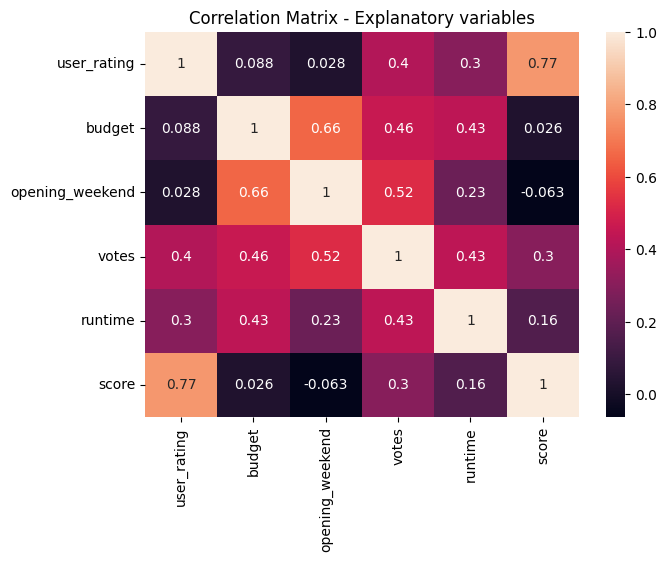

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# I decided to check collinearity between explanatory variables. 
x_variables = unified_view[["user_rating", "budget", "opening_weekend", "votes", "runtime", "score"]]
correlation_matrix = x_variables.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, cmap="rocket", annot=True)
plt.title("Correlation Matrix - Explanatory variables")
plt.show()

### Regresion Model including all the explanatory variables

In this model, the variables score and runtime do not have a statistically significant relationship with the response variable (gross sales). Score has a P-value = 0.331 > alpha = 0.05 and runtime has a p-value = 0.276 > alpha = 0.05.

In [5]:
import statsmodels.formula.api as sm

# Plot a linear relationship using all the numeric values we have at the same time. I decided to include score instead of user_rating.
ols_model = sm.ols(
    formula = "gross_sales ~ score + budget + opening_weekend + votes + runtime",
    data = unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     49.95
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           1.30e-23
Time:                        14:25:24   Log-Likelihood:                -1744.4
No. Observations:                  89   AIC:                             3501.
Df Residuals:                      83   BIC:                             3516.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.887e+05   5.78e+07     

### Regression model. Removing variables score and runtime

In this model, the explanatory variables budget, opening weekend, and votes have a statistically significant relationship with the response variable (P-value < alpha = 0.05). The Adj. R-squared increased slightly from the previous model. The model that has the largest value of Adj. R-squared is the best-fitting model. Therefore, I will keep this model as the final one.

Next, I evaluated the R-squared which is 0.746. This means that our model explains 74.6% of the change in our gross sales variable. In machine learning, the closer the value of the R squared is to 1, the more perfect the model is trained. Although we didn't split our data into training and test sets, I would say our regression model didn't perform too bad (R-squared > 0.5). However, if we were to implement a Machine Learning model with a result like the one we got, we will not have accurate gross sales predictions. For that, we would need at least a regression model with an R-squared of 0.9.


In [6]:
# Running again the regression analysis after removing variables score and runtime. 
ols_model = sm.ols(
    formula = "gross_sales ~ budget + opening_weekend + votes",
    data = unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     83.05
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.48e-25
Time:                        14:25:24   Log-Likelihood:                -1745.2
No. Observations:                  89   AIC:                             3498.
Df Residuals:                      85   BIC:                             3508.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -3.279e+07   1.48e+07     

# Adding AI into the notebook
---
## Construct a sentiment pipeline task
---

In this section is where the fun begins. I will construct a pipeline that takes raw text and turns that into an estimate of the text's sentiment.

In [7]:
import transformers

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = transformers.pipeline("sentiment-analysis", model = MODEL, 
                                       tokenizer=transformers.AutoTokenizer.from_pretrained(MODEL))

# When I first executed this, it gave a negative score of 
print(sentiment_task("Covid cases are increasing fast!"))

# This task gave a positive score of 
print(sentiment_task("I really love ice cream on a warn day!"))

# My attempt at something neutral
print(sentiment_task("The book Moby Dick was written by Herman Melville"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-10 14:25:35.081573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions with

[{'label': 'negative', 'score': 0.47410959005355835}]
[{'label': 'positive', 'score': 0.8833828568458557}]
[{'label': 'neutral', 'score': 0.7707719802856445}]


---
## Creating a sentiment function
---

Next, we construct a function to convert a movie's description into a number. This will make sentiment something that can be plotted on a chart. Positive numbers go from 0.5 up to 1.5, neutral numbers go from -0.5 up to 0.5, and negative numbers go from -0.5 to -1.5.

In [8]:
# Create a function to turn sentiment analysis object into a single number
def calculate_sentiment (text):
    if text is None:
        return 0
    sentiment = sentiment_task(text)
    if sentiment[0]["label"] == "negative":
        return 0 - sentiment[0]["score"] - 0.5
    elif sentiment[0]["label"] == "neutral":
        return sentiment[0]["score"] - 0.5
    elif sentiment[0]["label"] == "positive":
        return 1 + sentiment[0]["score"] - 0.5

# Test this function
print(calculate_sentiment("I came down with the flu and I'm feeling really sick"))
print(calculate_sentiment("Today is my birthday!"))
print(calculate_sentiment("The book Moby Dick was written by Herman Melville"))
print(calculate_sentiment(None))

-1.3941447138786316
1.243176281452179
0.27077198028564453
0


---
## Creating a new column in Pandas
---

In this section, we will create a new column called sentiment that will contain the values assigned by the sentiment function. The sentiment function will evaluate the description column. 

In [9]:
# First, we will apply a lambda to calculate sentiment for the movie in the dataset
# We use "row.get(description)" instead of row["description"] because it returns None if there is no description.
sentiment_column = unified_view.apply(lambda row : calculate_sentiment(row.get('description')), axis = 1)

# Next add this column back into the unified view
# Assigning it via an array indexer allows us to re-run this code block multiple times and replace the sentiment column
# so we can tinker with it and update the calculations
unified_view["sentiment"] = sentiment_column

# Debugging! Checking what we have
unified_view.head()

,_id_x,id,title,runtime,user_rating,votes,release_date_x,budget,opening_weekend,gross_sales,...,release_month,release_day,mpaa_rating,_id_y,movie_id,release_date_y,description,score,thumbnail,sentiment
0,65457710b3a97e2eaf71dc98,325980,Pirates of the Caribbean: The Curse of the Bla...,143,8.1,1099366,2003-06-28,140000000.0,46630690.0,6.542640e+08,...,6,28,PG-13,652ae14c2c4f46bad5ebb1f7,12569,2003-07-09,For the roguish yet charming Captain Jack Spar...,63,https://static.metacritic.com/images/products/...,0.864998
1,65457710b3a97e2eaf71dc99,167260,The Lord of the Rings: The Return of the King,201,9.0,1786092,2003-12-01,94000000.0,NaN,1.119930e+09,...,12,1,PG-13,652ae14c2c4f46bad5ebb15b,12413,2003-12-17,Sauron's forces have laid siege to Minas Tirit...,94,https://static.metacritic.com/images/products/...,-0.961539
2,65457710b3a97e2eaf71dc9a,314331,Love Actually,135,7.6,475531,2003-09-07,40000000.0,NaN,2.469420e+08,...,9,7,TV-14,652ae14c2c4f46bad5ebb234,12630,2003-11-07,This ultimate romantic comedy weaves together ...,55,https://static.metacritic.com/images/products/...,1.317835
3,65457710b3a97e2eaf71dc9b,266697,Kill Bill: Vol. 1,111,8.2,1089074,2003-09-29,30000000.0,22089322.0,1.809490e+08,...,9,29,R,652ae14c2c4f46bad5ebb1c4,12518,2003-10-10,An epic tale of one woman's quest for justice ...,69,https://static.metacritic.com/images/products/...,0.020143
4,65457710b3a97e2eaf71dc9e,325710,The Last Samurai,154,7.8,432809,2003-11-22,140000000.0,24271354.0,4.567590e+08,...,11,22,R,652ae14c2c4f46bad5ebb237,12633,2003-12-05,The paths of two warriors converge when the yo...,55,https://static.metacritic.com/images/products/...,-0.907136


---
## Does AI improve our forecasting?
---

The sentiment variable does not improve the forecasting. Because p-value = 0.754 > alpha = 0.05, we know this variable does not have a significant relationship with the response variable. However, it was a great experience to include AI in this analysis.

In [10]:
# Running a regression analysis including sentiment variable.
# It did not improve the model. 
ols_model = sm.ols(
    formula = "gross_sales ~ budget + opening_weekend + votes + sentiment",
    data = unified_view).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:            gross_sales   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     61.65
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           3.30e-24
Time:                        14:26:40   Log-Likelihood:                -1745.2
No. Observations:                  89   AIC:                             3500.
Df Residuals:                      84   BIC:                             3513.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -3.17e+07   1.53e+07     

---
## Charting data
---
### Comparison of Sentiment vs Score in 2003 Movies.

High and low scores can have negative, neutral and positive values for movies. Hence, sentiment is not related to score. This makes sense since the sentiment variable is based on the description of the movies.

Text(0.5, 1.0, 'Sentiment vs Score in 2003 Movies')

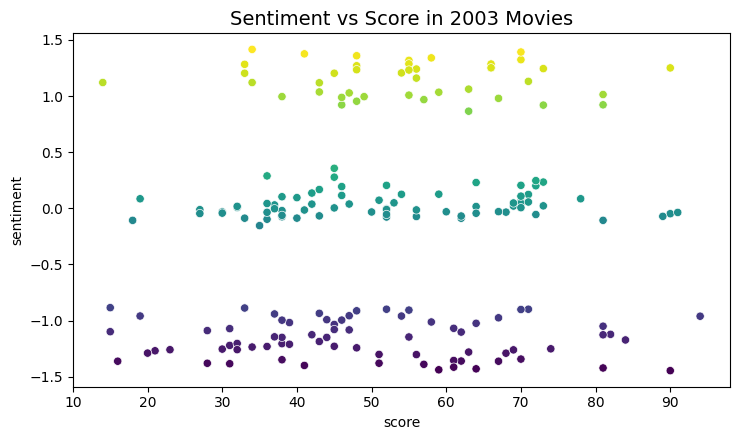

In [11]:
# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True
# Create scatterplot of sentiment vs score.
sns.scatterplot(data=unified_view, x= "score", y="sentiment", hue="sentiment", palette='viridis', legend=False)
plt.title("Sentiment vs Score in 2003 Movies", fontsize=14)

### Comparison of Number of Movies by Month in 2003

The month with the highest number of movies in 2003 was January followed by August and September.

Text(0, 0.5, 'Number of Movies')

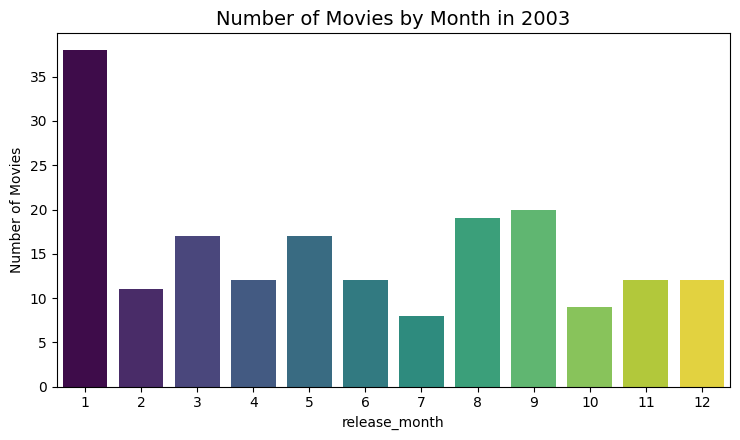

In [12]:
# Create a bar plot of number of movies by month
sns.countplot(data=unified_view, x="release_month", hue="release_month", legend=False, palette="viridis")
plt.title("Number of Movies by Month in 2003", fontsize=14)
plt.ylabel("Number of Movies")

### Boxplot of Gross sales month by month in 2003

The month with the highest average gross sale in 2003 was July with almost $200 millions in sales. As we saw in the previous chart, that month was one with the lowest number of movies released. However, it seems like it was a successfull month in terms of sales. Besides that, most of the months have an average gross sales around $100 milions.

Text(0.5, 1.0, 'Gross Sales by Release Month in 2003 Movies')

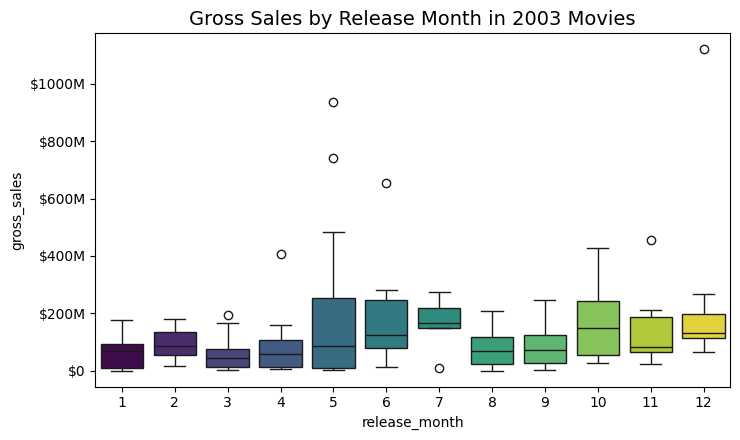

In [13]:
# A custom formatter for currency
def format_currency(amount, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"

# Chart trends over time with boxplots
plt.gca().yaxis.set_major_formatter(format_currency)
chart = sns.boxplot(data= unified_view, x="release_month", y= "gross_sales", hue="release_month", legend=False, palette="viridis")
chart.set_title('Gross Sales by Release Month in 2003 Movies', fontsize=14)


### Comparative histogram. Movies with positive, neutral and negative sentiment scores.
Movies with neutral sentiment score are the biggest group, followed by negative sentiment and lastly positive sentiment. I think the reason for this, as I mentioned in the first chart, is that the sentiment score is based on the description of the movies. Probably, most of the movies have a description with words that do not reflect either happiness or sadness. 

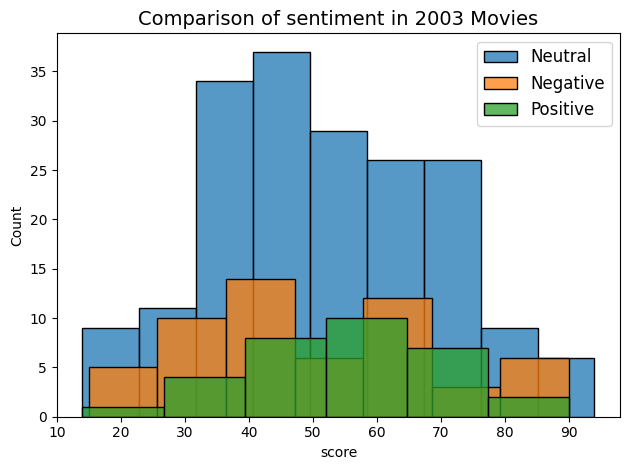

In [14]:
happy_movies = unified_view[unified_view['sentiment'] > 1].score
sad_movies = unified_view[unified_view['sentiment'] < -1].score
neutral_movies = unified_view[unified_view['sentiment'] -1 < 1].score

# Set the figure size
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.autolayout"] = True

# Create histogram
plt.title("Comparison of sentiment in 2003 Movies", fontsize= 14)
sns.histplot(neutral_movies, kde=False, label= "Neutral")
sns.histplot(sad_movies, kde=False, label= "Negative")
sns.histplot(happy_movies, kde=False, label= "Positive")
plt.legend(prop={'size': 12})


---
## Conclusion
---
Even though we created a sentiment score using AI, it did not improve the accuracy of our machine learning model. We have stated that the main reason could be the fact that the sentiment score evaluated movie description words. Apparently this does not influence gross sales. Our best-fitting model to predict gross sales included the explanatory variables budget, opening weekend, and votes. This model explains 74.6% of the change in our gross sales variable. This percentage is not too bad, but for machine learning purposes it is not the best. To improve this result we would need to find another explanatory variable that can offer a better prediction of movies gross sales. 